In [2]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *
DATA_DIR = '/work/users/k/4/k4thryn/Repos/OLD_EpSampling_Nov2024/data/'

pd.set_option('display.max_columns', None)

### Functions

In [3]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def get_model_df(df, X_COLS, Y_COL, NAIVE_COL):
    cols = ['Date', 'Fips'] + X_COLS + [Y_COL, NAIVE_COL]
    df = df[cols]    
    return df

def get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG):    
    X_train = df_train[X_COLS]
    y_train = df_train[Y_COL]
    X_test = df_test[X_COLS]
    
    df_pred = df_test.copy()
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    df_pred['Algorithm'] = ALG
    df_pred[PRED_COL] = reg.predict(X_test)
    
    return df_pred

# <font color=blue> 1) Dataset

In [4]:
from epsampling.utils import drop_duplicate_cols
ts = '20241108-123515'

fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
df = pd.read_csv(fpath)
df = df[df.True_county_inc_deaths >= 0]
display(df.columns)

fpath = os.path.join(DATA_DIR,'processed',f'training_acs_df_{ts}.csv')
df_acs = pd.read_csv(fpath)
df_acs.set_index('Fips',inplace=True)
df = df.join(df_acs,on='Fips')


# # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # 

df['Naive_delta'] = df.apply(lambda x: x.Naive_proj_deaths - x.True_county_inc_deaths,axis=1)

Y_COL = 'True_county_inc_deaths'
# Y_COL = 'Naive_delta'

tvarying_cols = ['True_county_inc_deaths_tm_4','True_county_inc_deaths_tm_5',
                 'True_county_inc_deaths_tm_6','True_county_inc_deaths_tm_7','True_county_inc_deaths_tm_8']
X_COLS = ['Ratio','Proj_state_inc_deaths','Pop'] + list(df_acs.columns) + tvarying_cols
to_remove = ['POP', 'POP_x3', 'HH_x6', 'POP_16p_EMP_x8', 'IND_CONS_x8', 
                  'IND_MAN_x8', 'IND_WHT_x8', 'IND_RETT_x8', 'IND_INF_x8', 
                  'IND_OSER_x8', 'IND_PUBA_x8', 'POP_16p_EMP_x10', 'POP_16p_EMP_x11',
                  'POP_16p_EMP', 'OCC_SERV_HCS_x12', 'OCC_SERV_FPS_x12', 
                  'OCC_SERV_BGM_x12', 'OCC_SERV_PCS_x12', 'OCC_SALES_SR_x12', 
                  'OCC_SALES_OAS_x12', 'OCC_NRCM_FFF_x12', 'OCC_NRCM_CE_x12', 
                  'OCC_NRCM_IMR_x12', 'OCC_PTMM_P_x12', 'OCC_PTMM_T_x12', 
                  'OCC_PTMM_MM_x12', 'POP_x13', 'POP_HISP_x13', 'POP_x14', 'HU_x15']
for x in to_remove:
    X_COLS.remove(x)

# X_COLS = ['Proj_state_inc_deaths', 'Pop']

NAIVE_COL = 'Naive_proj_deaths'

df.dropna(inplace=True)
df = df[df['True_county_inc_deaths'] >= 0]

# df = get_model_df(df, X_COLS, Y_COL, NAIVE_COL)
# df = drop_duplicate_cols(df)
# df.dropna(inplace=True)
# print(X_COLS)

Index(['Date', 'State_fips', 'Fips', 'Pop', 'State_pop', 'Ratio',
       'Proj_state_inc_deaths', 'True_state_inc_deaths',
       'True_county_cum_deaths', 'True_county_inc_deaths', 'Naive_proj_deaths',
       'Naive_true_deaths', 'True_county_inc_deaths_tm_4',
       'True_county_inc_deaths_tm_5', 'True_county_inc_deaths_tm_6',
       'True_county_inc_deaths_tm_7', 'True_county_inc_deaths_tm_8',
       'True_county_inc_deaths_tm_9', 'True_county_inc_deaths_tm_10',
       'True_county_inc_deaths_tm_11'],
      dtype='object')

In [5]:
df

,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,Naive_proj_deaths,Naive_true_deaths,True_county_inc_deaths_tm_4,True_county_inc_deaths_tm_5,True_county_inc_deaths_tm_6,True_county_inc_deaths_tm_7,True_county_inc_deaths_tm_8,True_county_inc_deaths_tm_9,True_county_inc_deaths_tm_10,True_county_inc_deaths_tm_11,POP,POP_M,POP_F,POP_A0004,POP_A0509,POP_A1014,POP_A1517,POP_A1819,POP_A20,POP_A21,POP_A2224,POP_A2529,POP_A3034,POP_A3539,POP_A4044,POP_A4549,POP_A5054,POP_A5559,POP_A6061,POP_A6264,POP_A6566,POP_A6769,POP_A7074,POP_A7579,POP_A8084,POP_A85p,POP_A25p,EDU_ltHS,EDU_HS,EDU_ASSOC,EDU_BACH,EDU_MAST,EDU_PROF,EDU_DOCT,POP_x3,POP_NH,POP_HISP_x12,POP_A3564,HINS_A0018,HINS_A1934,HINS_A3564,HINS_A65p,HH_x5,HH_1P,HH_2P,HH_3P,HH_4P,HH_5P,HH_6P,HH_7pP,HH_x6,HHI_00_10k,HHI_10_15k,HHI_15_20k,HHI_20_25k,HHI_25_30k,HHI_30_35k,HHI_35_40k,HHI_40_45k,HHI_45_50k,HHI_50_60k,HHI_60_75k,HHI_75_100k,HHI_100_125k,HHI_125_150k,HHI_150_200k,HHI_200k_p,POP_16p_EMP_x7,IND_AFFHM,IND_CONS_x7,IND_MAN_x7,IND_WHT_x7,IND_RETT_x7,IND_TWU,IND_INF_x7,IND_FIRR,IND_PSMAW,IND_EHCSA,IND_AERAF,IND_OSER_x7,IND_PUBA_x7,POP_16p_EMP_x8,IND_AFFHM_AFFH,IND_AFFHM_MQE,IND_CONS_x8,IND_MAN_x8,IND_WHT_x8,IND_RETT_x8,IND_TWU_TW,IND_TWU_U,IND_INF_x8,IND_FIRR_FI,IND_FIRR_RR,IND_PSMAW_PST,IND_PSMAW_M,IND_PSMAW_ASWM,IND_EHCSA_E,IND_EHCSA_HCSA,IND_AERAF_AER,IND_AERAF_AF,IND_OSER_x8,IND_PUBA_x8,HU_x14,HU_OCC,HU_VAC,HU_OCC_OWN,HU_OCC_RENT,HU_OCC_OPRlt050,HU_OCC_OPR051100,HU_OCC_OPR101150,HU_OCC_OPR151200,HU_OCC_OPRgt200,POP_16p_EMP_x10,OCC_MBSA,OCC_SERV,OCC_SALES,OCC_NRCM,OCC_PTMM,POP_16p_EMP_x11,OCC_MBSA_MBF,OCC_MBSA_CES,OCC_MBSA_ELCAM,OCC_MBSA_HCPT,OCC_SERV_HCS_x11,OCC_SERV_PS,OCC_SERV_FPS_x11,OCC_SERV_BGM_x11,OCC_SERV_PCS_x11,OCC_SALES_SR_x11,OCC_SALES_OAS_x11,OCC_NRCM_FFF_x11,OCC_NRCM_CE_x11,OCC_NRCM_IMR_x11,OCC_PTMM_P_x11,OCC_PTMM_T_x11,OCC_PTMM_MM_x11,POP_16p_EMP,OCC_MBSA_MBF_M,OCC_MBSA_MBF_BF,OCC_MBSA_CES_CM,OCC_MBSA_CES_AE,OCC_MBSA_CES_LPSS,OCC_MBSA_ELCAM_CSS,OCC_MBSA_ELCAM_L,OCC_MBSA_ELCAM_EL,OCC_MBSA_ELCAM_ADESM,OCC_MBSA_HCPT_HDTP,OCC_MBSA_HCPT_HTT,OCC_SERV_HCS_x12,OCC_SERV_PS_FP,OCC_SERV_PS_LE,OCC_SERV_FPS_x12,OCC_SERV_BGM_x12,OCC_SERV_PCS_x12,OCC_SALES_SR_x12,OCC_SALES_OAS_x12,OCC_NRCM_FFF_x12,OCC_NRCM_CE_x12,OCC_NRCM_IMR_x12,OCC_PTMM_P_x12,OCC_PTMM_T_x12,OCC_PTMM_MM_x12,POP_x13,POP_WHITENH,POP_BLACKNH,POP_AIANNH,POP_ASIANNH,POP_NHPINH,POP_OTH2PLNH,POP_HISP_x13,POP_x14,POP_WHITE,POP_BLACK,POP_AIAN,POP_ASIAN,POP_NHPI,POP_OTH2PL,HU_x15,HU_UIS01D,HU_UIS01A,HU_UIS02,HU_UIS0304,HU_UIS0509,HU_UIS1019,HU_UIS2049,HU_UIS50P,HU_UISOTHER,Naive_delta
11,20200905,37,37001,169185,10367022,0.016320,157.0,205.0,46.0,0.0,2.562167,3.345505,0.0,1.0,1.0,2.0,0.0,1.0,1.0,3.0,169185,0.476916,0.523084,0.057529,0.061714,0.064805,0.039111,0.039572,0.016627,0.015055,0.034377,0.061684,0.062104,0.060053,0.056353,0.063605,0.068209,0.072099,0.027349,0.032976,0.022963,0.031859,0.042350,0.026462,0.022461,0.020687,113559,0.122870,0.505129,0.108525,0.184917,0.058190,0.008885,0.011483,169185,0.868913,0.131087,64210,0.950645,0.818370,0.858916,0.990567,66311,0.297703,0.344407,0.161979,0.122408,0.045075,0.021037,0.007389,66311,0.059538,0.045422,0.056687,0.050655,0.058678,0.053204,0.042286,0.047157,0.046327,0.076684,0.095369,0.132120,0.092971,0.056808,0.050716,0.035379,79356,0.006364,0.076781,0.152906,0.030697,0.131383,0.045025,0.009577,0.048402,0.086874,0.252747,0.079313,0.040690,0.039241,79356,0.005973,0.000391,0.076781,0.152906,0.030697,0.131383,0.037754,0.007271,0.009577,0.035372,0.013030,0.042429,0.000113,0.044332,0.096691,0.156056,0.013635,0.065679,0.040690,0.039241,72651,0.912733,0.087267,0.607397,0.305336,0.673067,0.223589,0.013792,0.002092,0.000193,79356,0.336521,0.161361,0.230581,0.095393,0.176143,79356,0.132996,0.048629,0.090352,0.064545,0.024762,0.021133,0.054199,0.040967,0.020301,0.105537,0.125044,0.002684,0.053228,0.039480,0.096653,0.032108,0.047381,79356,0.088941,0.044055,0.021637,0.016218,0.010774,0.016533,0.002949,

In [6]:
len(X_COLS)

165

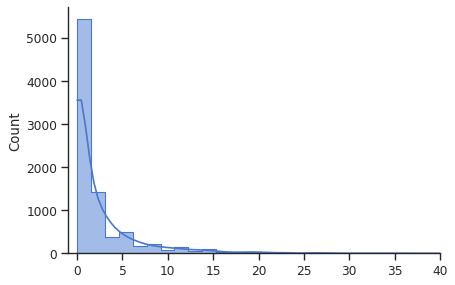

Are all targets non-negative? True


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 
DPI = 80
FIGSIZE = (6,4)

plt.figure(figsize=FIGSIZE)
sns.histplot(df[Y_COL].values, bins=60, kde=True, element='step')
sns.despine()
plt.xlim((-1, 40))
plt.gcf().set_dpi(DPI)
plt.show()

print(f"Are all targets non-negative? {(df[Y_COL].min() >= 0)}")

## <font color=blue> 2) Training: County population + Predicted state deaths

    
<font color=blue> _Compare regression algorithms:_
1. <font color=blue>  Linear 
1. <font color=blue>  Poisson 
1. <font color=blue>  Zero-inflated
    
This is our most simplistic model. We are predicting the number of county deaths given two covariates: 1) projected state deaths (from COVIDHub) and 2) county population. We will consider vanilla linear regression, poisson regression, and zero-inflated regression.

### <font color=blue> Model design
- <font color=blue> **_Train-test split:_** Our training and test/evaluation set will be partitioned based on (2 month)-wise chunks. That is, we will evaluate our model on temporally consecutive targets over the course of 8 weeks, and we will train on the remaining weeks.
    - <font color=black> **Train samps:** 7939
    - <font color=black> **Test samps:** 771
- <font color=blue> **_Cross validation protocol:_** We will train a model for each month, for a total of 10 models. From these, we can evaluate average performance for each regression algorithm.
    

In [8]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklego.meta import ZeroInflatedRegressor as zir_model
from sklearn.svm import SVC
import statsmodels.api as sm

from catboost import CatBoostRegressor, Pool

def get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG):  
    scaler = StandardScaler()
    X_train = df_train[X_COLS]
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    y_train = df_train[Y_COL]
    X_test = df_test[X_COLS]
    X_test = scaler.transform(X_test)

    df_pred = df_test.copy()
    
    if ALG=='Poisson':
        X_train = sm.add_constant(X_train)
        reg = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=0.5)).fit()
        df_pred['Algorithm'] = ALG
        X_test = sm.add_constant(X_test)
        df_pred[PRED_COL] = reg.predict(X_test)
        return reg, df_pred

    
    if ALG=='Linear':
        reg = linear_model.LinearRegression().fit(X_train, y_train)
#     elif ALG=='Poisson':
#         reg = linear_model.PoissonRegressor().fit(X_train, y_train)
    elif ALG=='ZIR':
        reg = zir_model(
            classifier=SVC(),
            regressor=linear_model.LinearRegression()).fit(X_train, y_train) 
        
            
    df_pred['Algorithm'] = ALG
    df_pred[PRED_COL] = reg.predict(X_test)
    
    return reg, df_pred


# ALG = 'Linear Regression'

res_dfs = []
regs = []
models = {}
chunks = get_chunks(list(df.Date.unique()), num_membs=8)

my_algs = ['Linear', 'Poisson', 'Naive']

for ALG in my_algs:
    for i,test_chunk in tqdm(enumerate(chunks), total=len(chunks)):

        df_train, df_test = get_date_chunked_splits(df, chunks, i)
        
        df_test[f'Run'] = i
        PRED_COL = 'PRED county deaths' 
        
        if ALG=='Naive':
            df_res = df_test
            df_res['Algorithm'] = 'Naive'
            df_res[PRED_COL] = df_res[NAIVE_COL]
        else:
            PRED_COL = 'PRED county deaths'   
            reg, df_res = get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL=PRED_COL, ALG=ALG)
            regs.append(reg)

        res_dfs.append(df_res)
        
    
df_full_res = pd.concat(res_dfs)
display(df_full_res)

100%|██████████| 11/11 [00:00<00:00, 198.64it/s]


,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,Naive_proj_deaths,Naive_true_deaths,True_county_inc_deaths_tm_4,True_county_inc_deaths_tm_5,True_county_inc_deaths_tm_6,True_county_inc_deaths_tm_7,True_county_inc_deaths_tm_8,True_county_inc_deaths_tm_9,True_county_inc_deaths_tm_10,True_county_inc_deaths_tm_11,POP,POP_M,POP_F,POP_A0004,POP_A0509,POP_A1014,POP_A1517,POP_A1819,POP_A20,POP_A21,POP_A2224,POP_A2529,POP_A3034,POP_A3539,POP_A4044,POP_A4549,POP_A5054,POP_A5559,POP_A6061,POP_A6264,POP_A6566,POP_A6769,POP_A7074,POP_A7579,POP_A8084,POP_A85p,POP_A25p,EDU_ltHS,EDU_HS,EDU_ASSOC,EDU_BACH,EDU_MAST,EDU_PROF,EDU_DOCT,POP_x3,POP_NH,POP_HISP_x12,POP_A3564,HINS_A0018,HINS_A1934,HINS_A3564,HINS_A65p,HH_x5,HH_1P,HH_2P,HH_3P,HH_4P,HH_5P,HH_6P,HH_7pP,HH_x6,HHI_00_10k,HHI_10_15k,HHI_15_20k,HHI_20_25k,HHI_25_30k,HHI_30_35k,HHI_35_40k,HHI_40_45k,HHI_45_50k,HHI_50_60k,HHI_60_75k,HHI_75_100k,HHI_100_125k,HHI_125_150k,HHI_150_200k,HHI_200k_p,POP_16p_EMP_x7,IND_AFFHM,IND_CONS_x7,IND_MAN_x7,IND_WHT_x7,IND_RETT_x7,IND_TWU,IND_INF_x7,IND_FIRR,IND_PSMAW,IND_EHCSA,IND_AERAF,IND_OSER_x7,IND_PUBA_x7,POP_16p_EMP_x8,IND_AFFHM_AFFH,IND_AFFHM_MQE,IND_CONS_x8,IND_MAN_x8,IND_WHT_x8,IND_RETT_x8,IND_TWU_TW,IND_TWU_U,IND_INF_x8,IND_FIRR_FI,IND_FIRR_RR,IND_PSMAW_PST,IND_PSMAW_M,IND_PSMAW_ASWM,IND_EHCSA_E,IND_EHCSA_HCSA,IND_AERAF_AER,IND_AERAF_AF,IND_OSER_x8,IND_PUBA_x8,HU_x14,HU_OCC,HU_VAC,HU_OCC_OWN,HU_OCC_RENT,HU_OCC_OPRlt050,HU_OCC_OPR051100,HU_OCC_OPR101150,HU_OCC_OPR151200,HU_OCC_OPRgt200,POP_16p_EMP_x10,OCC_MBSA,OCC_SERV,OCC_SALES,OCC_NRCM,OCC_PTMM,POP_16p_EMP_x11,OCC_MBSA_MBF,OCC_MBSA_CES,OCC_MBSA_ELCAM,OCC_MBSA_HCPT,OCC_SERV_HCS_x11,OCC_SERV_PS,OCC_SERV_FPS_x11,OCC_SERV_BGM_x11,OCC_SERV_PCS_x11,OCC_SALES_SR_x11,OCC_SALES_OAS_x11,OCC_NRCM_FFF_x11,OCC_NRCM_CE_x11,OCC_NRCM_IMR_x11,OCC_PTMM_P_x11,OCC_PTMM_T_x11,OCC_PTMM_MM_x11,POP_16p_EMP,OCC_MBSA_MBF_M,OCC_MBSA_MBF_BF,OCC_MBSA_CES_CM,OCC_MBSA_CES_AE,OCC_MBSA_CES_LPSS,OCC_MBSA_ELCAM_CSS,OCC_MBSA_ELCAM_L,OCC_MBSA_ELCAM_EL,OCC_MBSA_ELCAM_ADESM,OCC_MBSA_HCPT_HDTP,OCC_MBSA_HCPT_HTT,OCC_SERV_HCS_x12,OCC_SERV_PS_FP,OCC_SERV_PS_LE,OCC_SERV_FPS_x12,OCC_SERV_BGM_x12,OCC_SERV_PCS_x12,OCC_SALES_SR_x12,OCC_SALES_OAS_x12,OCC_NRCM_FFF_x12,OCC_NRCM_CE_x12,OCC_NRCM_IMR_x12,OCC_PTMM_P_x12,OCC_PTMM_T_x12,OCC_PTMM_MM_x12,POP_x13,POP_WHITENH,POP_BLACKNH,POP_AIANNH,POP_ASIANNH,POP_NHPINH,POP_OTH2PLNH,POP_HISP_x13,POP_x14,POP_WHITE,POP_BLACK,POP_AIAN,POP_ASIAN,POP_NHPI,POP_OTH2PL,HU_x15,HU_UIS01D,HU_UIS01A,HU_UIS02,HU_UIS0304,HU_UIS0509,HU_UIS1019,HU_UIS2049,HU_UIS50P,HU_UISOTHER,Naive_delta,Run,Algorithm,PRED county deaths
11,20200905,37,37001,169185,10367022,0.016320,157.0,205.0,46.0,0.0,2.562167,3.345505,0.0,1.0,1.0,2.0,0.0,1.0,1.0,3.0,169185,0.476916,0.523084,0.057529,0.061714,0.064805,0.039111,0.039572,0.016627,0.015055,0.034377,0.061684,0.062104,0.060053,0.056353,0.063605,0.068209,0.072099,0.027349,0.032976,0.022963,0.031859,0.042350,0.026462,0.022461,0.020687,113559,0.122870,0.505129,0.108525,0.184917,0.058190,0.008885,0.011483,169185,0.868913,0.131087,64210,0.950645,0.818370,0.858916,0.990567,66311,0.297703,0.344407,0.161979,0.122408,0.045075,0.021037,0.007389,66311,0.059538,0.045422,0.056687,0.050655,0.058678,0.053204,0.042286,0.047157,0.046327,0.076684,0.095369,0.132120,0.092971,0.056808,0.050716,0.035379,79356,0.006364,0.076781,0.152906,0.030697,0.131383,0.045025,0.009577,0.048402,0.086874,0.252747,0.079313,0.040690,0.039241,79356,0.005973,0.000391,0.076781,0.152906,0.030697,0.131383,0.037754,0.007271,0.009577,0.035372,0.013030,0.042429,0.000113,0.044332,0.096691,0.156056,0.013635,0.065679,0.040690,0.039241,72651,0.912733,0.087267,0.607397,0.305336,0.673067,0.223589,0.013792,0.002092,0.000193,79356,0.336521,0.161361,0.230581,0.095393,0.176143,79356,0.132996,0.048629,0.090352,0.064545,0.024762,0.021133,0.054199,0.040967,0.020301,0.105537,0.125044,0.002684,0.053228,0.039480,0.096653,0.032108,0.047381,79356,0.088941,0.044055,0.021637,0.0

In [9]:
# df_full_res['PRED county deaths'] = df_full_res.apply(lambda x: x.Naive_proj_deaths - x.PRED_delta, axis=1)

In [10]:
# TRUNCATE TO 0!
# df_full_res['PRED county deaths'][df_full_res['PRED county deaths'] < 0] = 0 

## <font color=blue> 3) Evaluation

In [11]:
## GET PERFORMANCE !
# from epsampling.modeling import get_metrics_ser

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def get_metrics_ser(df, target_col, pred_col, alg_col, naive_col):
    
    metrics_dict = {'MAE': mean_absolute_error,
                    'MedAE': median_absolute_error,
                    'MSE': mean_squared_error,
                    'RMSE': mean_squared_error,
                    'r2': r2_score
                    }
    
    mae = mean_absolute_error(df[target_col], df[pred_col])
    medae = median_absolute_error(df[target_col], df[pred_col])
    r2 = r2_score(df[target_col], df[pred_col])
    mse = mean_squared_error(df[target_col], df[pred_col])
    
    relmae = mae / mean_absolute_error(df[target_col],df[naive_col])
    
    ser = {'Algorithm':alg_col, 'MAE':mae, 'MedAE':medae, 
           'R-squared':r2, 'MSE': mse, 'relMAE': relmae,}
    
    return ser
    

metric_sers = []

# for alg in df_full_res.Algorithm.unique():
#     for run in df_full_res.Run.unique():

#         subdf = df_full_res[(df_full_res['Run']==run) & (df_full_res['Algorithm']==alg)]
#         ser = get_metrics_ser(subdf, 
#                               target_col=Y_COL,
#                               pred_col='PRED county deaths',
#                               alg_col=alg,
#                               naive_col=NAIVE_COL)

#         metric_sers.append(ser)
        
for alg in df_full_res.Algorithm.unique():


    subdf = df_full_res[df_full_res['Algorithm']==alg]
    ser = get_metrics_ser(subdf, 
                          target_col=Y_COL,
                          pred_col='PRED county deaths',
                          alg_col=alg,
                          naive_col=NAIVE_COL)

    metric_sers.append(ser)
    
df_run = pd.DataFrame(metric_sers)
df_run

,Algorithm,MAE,MedAE,R-squared,MSE,relMAE
0,Linear,2.190548,1.315503,0.331395,16.312590,1.070890
1,Poisson,1.915168,0.993742,0.411773,14.351529,0.936265
2,Naive,2.045540,0.812144,0.169692,20.257800,1.000000


In [ ]:
# for alg in my_algs:
#     print(alg)
#     print(df_run[df_run.Algorithm==alg]['relMAE'].mean())
#     print(df_run[df_run.Algorithm==alg]['MAE'].mean())
#     print(df_run[df_run.Algorithm==alg]['R-squared'].mean())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 

figsize = (8,6)
alpha = 0.7
size = 10
linewidth = .3

DPI = 200
FIGSIZE = (6,6)
plt.figure(figsize=FIGSIZE)

sns.scatterplot(data=df_full_res, x='True_county_inc_deaths', y='PRED county deaths', alpha=alpha, 
                linewidth=linewidth, edgecolors='k',hue='Algorithm',s=size, 
#                 palette='turbo',
                palette=['aqua','greenyellow','orange','magenta']
               ) #, palette=['coral','chartreuse','aqua'])

plt.plot([0, 90], [0, 90],linestyle='--', color='k')

sns.despine()
plt.xlim((0, 90))
plt.ylim((0, 90))
plt.gcf().set_dpi(DPI)
plt.show()

In [ ]:
for alg,c in zip(my_algs,['aqua','greenyellow','orange','magenta']):
    figsize = (8,6)
    alpha = 0.7
    size = 10
    linewidth = .5

    DPI = 80
    FIGSIZE = (6,6)
    plt.figure(figsize=FIGSIZE)

    to_plot = df_full_res[df_full_res.Algorithm==alg]
    sns.scatterplot(data=to_plot, x='True_county_inc_deaths', y='PRED county deaths', alpha=alpha, 
                    linewidth=linewidth, edgecolors='k', s=size, color=c)
    plt.plot([0, 90], [0, 90],linestyle='--', color='k')


    sns.despine()
    plt.title(alg)
    plt.xlim((0, 90))
    plt.ylim((0, 90))    
    plt.gcf().set_dpi(DPI)
    plt.show()    

### <font color=magenta> ToDo: make new dataframe with column for each model result. try to find any relationship between error and some covariate.

In [ ]:
df_lin = df_full_res[df_full_res.Algorithm=='Poisson']
df_lin.rename({'PRED county deaths':'Poisson'},axis=1,inplace=True)

# df_lin['Poisson'] = df_full_res[df_full_res.Algorithm=='Poisson']['PRED county deaths']
# df_lin.drop('Algorithm',axis=1,inplace=True)

# df_lin['Linear_error'] = abs(df_lin['True_county_inc_deaths'] - df_lin['Linear'])
df_lin['Poisson_error'] = df_lin['Poisson'] - df_lin['True_county_inc_deaths']
df_lin

In [ ]:
df_lin['UnderOver'] = df_lin.Poisson_error.apply(lambda x: -1 if x < 0 else 1)
df_lin

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 
DPI = 80
FIGSIZE = (6,4)

plt.figure(figsize=FIGSIZE)
sns.histplot(df_lin['Poisson_error'].values,  kde=False, element='step')
sns.despine()
# plt.xlim((-1, 40))
plt.gcf().set_dpi(DPI)
plt.show()

In [ ]:
# algs = df_full_res["Algorithm"].unique()
# alpha = 1
# for alg in algs:
#     print(alg)
    
#     josh_df = df_full_res[df_full_res["Algorithm"] == alg]
#     plt.figure()
#     sns.displot(data=josh_df, x='True_county_inc_deaths', y='PRED county deaths', alpha=alpha, 
#                 linewidth=linewidth, kind = "kde")
#     plt.xlim((0,30))
#     plt.ylim((0,30))
#     plt.title(alg)
    

In [ ]:
algs